In [9]:
from time import perf_counter
from dotenv import load_dotenv
import tiktoken
from openai import OpenAI
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

load_dotenv()

encoding = tiktoken.encoding_for_model('gpt-3.5-turbo') 
client = OpenAI()

In [13]:
def add_to_dataframe(results):
    global test_results
    test_results = pd.concat([test_results, pd.DataFrame(results, index=[0])], ignore_index=True)

In [14]:
def time_request(prompt: str):
    t0 = perf_counter()
    chat_completion = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[{"role": "user", "content": prompt}]
    )
    t1 = perf_counter()
    output = chat_completion.choices[0].message.content
    input_tokens = len(encoding.encode(prompt))
    output_tokens = len(encoding.encode(output))
    total_tokens = input_tokens + output_tokens
    
    return {
        "time": t1 - t0,
        "input_tokens": input_tokens,
        "output_tokens": output_tokens,
        "total_tokens": total_tokens,
        "output": output
    }

In [15]:
def visualize_data(df):
    # Scatter plot for time vs. total tokens
    sns.scatterplot(data=df, x="total_tokens", y="time")
    plt.xlabel("Total Tokens")
    plt.ylabel("Time (seconds)")
    plt.title("Time vs. Total Tokens")
    plt.show()


In [63]:
import numpy as np
from scipy.interpolate import griddata
from mpl_toolkits.mplot3d import Axes3D

def visualize_data_3d_surface(df):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Data for scatter plot
    xs = df['input_tokens']
    ys = df['output_tokens']
    zs = df['time']
    ax.scatter(xs, ys, zs)

    # Creating a grid for surface plot
    xi = np.linspace(xs.min(), xs.max(), 100)
    yi = np.linspace(ys.min(), ys.max(), 100)
    xi, yi = np.meshgrid(xi, yi)

    # Interpolating z values on the grid
    zi = griddata((xs, ys), zs, (xi, yi), method='linear')

    # Plotting the surface
    ax.plot_surface(xi, yi, zi, alpha=0.5, cmap='coolwarm')

    ax.set_xlabel('Input Tokens')
    ax.set_ylabel('Output Tokens')
    ax.set_zlabel('Time (seconds)')

    plt.title('3D Surface Plot of Complexity vs. Output Tokens vs. Time')
    plt.show()
    
def get_complexity(prompt):

    complexity_extraction_prompt = f"""
    Rate the complexity of this question on a scale of 1-10, with 1 being the least complex and 10 being the most complex.

    << PROMPT BEGINS >>

    {prompt}

    << PROMPT ENDS >>

    Respond with a number between 1 and 10 and no other information.
"""

    chat_completion = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[{"role": "user", "content": complexity_extraction_prompt}]
    )

    output = int(chat_completion.choices[0].message.content[0])
    return output

In [64]:
prompts = [
    """
John is 16 and lives in Boston. He is a student and enjoys playing soccer.
Jim is 25 and lives in New York City. He is a lawyer and enjoys playing tennis.

A person can be scored according to their age and the popularity of the sport they play where 0 is no one playing is and 10 is the most popular sport in the world.
The Equation is this:

score = age * sport popularity

Answer these three questions:
What are the steps to calculate the value of John and Jim?
What are their scores?
What is the difference in their value?
""",
"""

Answer a question about this passage:

In today’s idea-driven economy, the cost of time is what
really matters. With the constant pressure to innovate, it
makes little sense to waste countless collective hours
commuting. So, the most efficient and productive regions are
those in which people are thinking and working—not sitting
in traffic.
The auto-dependent transportation system has reached its
limit in most major cities and megaregions. Commuting by
car is among the least efficient of all our activities—not to
mention among the least enjoyable, according to detailed
research by the Nobel Prize–winning economist Daniel
Kahneman and his colleagues. Though one might think that
the economic crisis beginning in 2007 would have reduced
traffic (high unemployment means fewer workers traveling to
and from work), the opposite has been true. Average
commutes have lengthened, and congestion has gotten worse,
if anything. The average commute rose in 2008 to
25.5 minutes, “erasing years of decreases to stand at the level
of 2000, as people had to leave home earlier in the morning to
pick up friends for their ride to work or to catch a bus or
subway train,” according to the U.S. Census Bureau, which
collects the figures. And those are average figures. Commutes
are far longer in the big West Coast cities of Los Angeles and
San Francisco and the East Coast cities of New York,
Philadelphia, Baltimore, and Washington, D.C. In many of
these cities, gridlock has become the norm, not just at rush
hour but all day, every day.
The costs are astounding. In Los Angeles, congestion eats
up more than 485 million working hours a year; that’s seventy
hours, or nearly two weeks, of full-time work per commuter.
In D.C., the time cost of congestion is sixty-two hours per
worker per year. In New York it’s forty-four hours. Average it
out, and the time cost across America’s thirteen biggest city
regions is fifty-one hours per worker per year. Across the
country, commuting wastes 4.2 billion hours of work time
annually—nearly a full workweek for every commuter. The
overall cost to the U.S. economy is nearly $90 billion when lost
productivity and wasted fuel are taken into account. At the
Martin Prosperity Institute, we calculate that every minute
shaved off America’s commuting time is worth $19.5 billion in
value added to the economy. The numbers add up fast: five
minutes is worth $97.7 billion; ten minutes, $195 billion;
fifteen minutes, $292 billion.
It’s ironic that so many people still believe the main
remedy for traffic congestion is to build more roads and
highways, which of course only makes the problem worse.
New roads generate higher levels of “induced traffic,” that is,
new roads just invite drivers to drive more and lure people
who take mass transit back to their cars. Eventually, we end up
with more clogged roads rather than a long-term
improvement in traffic flow.
The coming decades will likely see more intense clustering
of jobs, innovation, and productivity in a smaller number of
bigger cities and city-regions. Some regions could end up
bloated beyond the capacity of their infrastructure, while
others struggle, their promise stymied by inadequate human
or other resources.

Question, Answer with the letter than corresponds to the answer you think is correct:

The passage most strongly suggests that researchers at the Martin
Prosperity Institute share which assumption?
A) Employees who work from home are more valuable to their employers
than employees who commute.
B) Employees whose commutes are shortened will use the time saved to
do additional productive work for their employers.
C) Employees can conduct business activities, such as composing memos
or joining conference calls, while commuting.
D) Employees who have longer commutes tend to make more money than
employees who have shorter commutes.
""",
"""

Answer a question about this passage:

In today’s idea-driven economy, the cost of time is what
really matters. With the constant pressure to innovate, it
makes little sense to waste countless collective hours
commuting. So, the most efficient and productive regions are
those in which people are thinking and working—not sitting
in traffic.
The auto-dependent transportation system has reached its
limit in most major cities and megaregions. Commuting by
car is among the least efficient of all our activities—not to
mention among the least enjoyable, according to detailed
research by the Nobel Prize–winning economist Daniel
Kahneman and his colleagues. Though one might think that
the economic crisis beginning in 2007 would have reduced
traffic (high unemployment means fewer workers traveling to
and from work), the opposite has been true. Average
commutes have lengthened, and congestion has gotten worse,
if anything. The average commute rose in 2008 to
25.5 minutes, “erasing years of decreases to stand at the level
of 2000, as people had to leave home earlier in the morning to
pick up friends for their ride to work or to catch a bus or
subway train,” according to the U.S. Census Bureau, which
collects the figures. And those are average figures. Commutes
are far longer in the big West Coast cities of Los Angeles and
San Francisco and the East Coast cities of New York,
Philadelphia, Baltimore, and Washington, D.C. In many of
these cities, gridlock has become the norm, not just at rush
hour but all day, every day.
The costs are astounding. In Los Angeles, congestion eats
up more than 485 million working hours a year; that’s seventy
hours, or nearly two weeks, of full-time work per commuter.
In D.C., the time cost of congestion is sixty-two hours per
worker per year. In New York it’s forty-four hours. Average it
out, and the time cost across America’s thirteen biggest city
regions is fifty-one hours per worker per year. Across the
country, commuting wastes 4.2 billion hours of work time
annually—nearly a full workweek for every commuter. The
overall cost to the U.S. economy is nearly $90 billion when lost
productivity and wasted fuel are taken into account. At the
Martin Prosperity Institute, we calculate that every minute
shaved off America’s commuting time is worth $19.5 billion in
value added to the economy. The numbers add up fast: five
minutes is worth $97.7 billion; ten minutes, $195 billion;
fifteen minutes, $292 billion.
It’s ironic that so many people still believe the main
remedy for traffic congestion is to build more roads and
highways, which of course only makes the problem worse.
New roads generate higher levels of “induced traffic,” that is,
new roads just invite drivers to drive more and lure people
who take mass transit back to their cars. Eventually, we end up
with more clogged roads rather than a long-term
improvement in traffic flow.
The coming decades will likely see more intense clustering
of jobs, innovation, and productivity in a smaller number of
bigger cities and city-regions. Some regions could end up
bloated beyond the capacity of their infrastructure, while
others struggle, their promise stymied by inadequate human
or other resources.

Explain how the article relates to the question then answer with the letter than corresponds to the answer you think is correct:

The passage most strongly suggests that researchers at the Martin
Prosperity Institute share which assumption?
A) Employees who work from home are more valuable to their employers
than employees who commute.
B) Employees whose commutes are shortened will use the time saved to
do additional productive work for their employers.
C) Employees can conduct business activities, such as composing memos
or joining conference calls, while commuting.
D) Employees who have longer commutes tend to make more money than
employees who have shorter commutes.
""",

"""
Write a 3 paragraph essay on the importance of beans in the human diet.
""",

"""
I want to cook something tonight.

The ingredients I have are:

- Flour

- Sugar

- Steak

- Butter

- Beans

- Ice Cream

- Cream Cheese

- Water

- Baking Soda


You don't need to use everything but can you walk me through a few options and then suggest a dish to create and write step by step instructions on how to mae it?
""",
"""
Write an 8 paragraph essay on the HoloCaust with the following sections.

1. History Leading up to the HoloCaust
2. Major Characters and historical events motivating the Holocaust
3. The beggining of the Holocaust
4. Major instigators during the Holocaust
5. Major players in the stopping of the Holocaust
6. The strengths of the players stopping the Holocaust
7. the weakness' o the players stopping the Holocaust
8. The conclusion of the Holocaust

Go into as much depth as you can for each topic
""",
"""
Write as much as you can about the following topic:

The importance of the internet in the modern world.
""",

"""
Provide a long summary of all Harry Potter Novels
""",
"""
Write a song with a chorus, 3 verses and a bridge.
Also include a chord progression for each part of the song
""",
"""
There are two ducks in front of a duck, two ducks behind a duck and a duck in the middle. How many ducks are there?
""",
"""
There are two ducks in front of a duck, two ducks behind a duck and a duck in the middle. How many ducks are there?


Explain step by step how you got your answer.
""",
"""
Jack is looking at Anne. Anne is looking at George. Jack is married, George is not, and we don’t know if Anne is married. Is a married person looking at an unmarried person?
""",
"""
Logic Puzzle: This “burning rope” problem is a classic logic puzzle. You have two ropes that each take an hour to burn, but burn at inconsistent rates. How can you measure 45 minutes? (You can light one or both ropes at one or both ends at the same time.)


Explain step by step how to think about getting an answer to this question.
""",
"""
Take this text and summarize it and try to infer what might come next and key questions the paper should uncover.

TEXT:
1 Introduction
Recurrent neural networks, long short-term memory [13] and gated recurrent [7] neural networks
in particular, have been firmly established as state of the art approaches in sequence modeling and
transduction problems such as language modeling and machine translation [ 35 , 2 , 5]. Numerous
efforts have since continued to push the boundaries of recurrent language models and encoder-decoder
architectures [38, 24, 15].
Recurrent models typically factor computation along the symbol positions of the input and output
sequences. Aligning the positions to steps in computation time, they generate a sequence of hidden
states ht, as a function of the previous hidden state ht−1 and the input for position t. This inherently
sequential nature precludes parallelization within training examples, which becomes critical at longer
sequence lengths, as memory constraints limit batching across examples. Recent work has achieved
significant improvements in computational efficiency through factorization tricks [ 21 ] and conditional
computation [ 32 ], while also improving model performance in case of the latter. The fundamental
constraint of sequential computation, however, remains.
Attention mechanisms have become an integral part of compelling sequence modeling and transduc-
tion models in various tasks, allowing modeling of dependencies without regard to their distance in
the input or output sequences [ 2, 19 ]. In all but a few cases [ 27 ], however, such attention mechanisms
are used in conjunction with a recurrent network.
In this work we propose the Transformer, a model architecture eschewing recurrence and instead
relying entirely on an attention mechanism to draw global dependencies between input and output.
The Transformer allows for significantly more parallelization and can reach a new state of the art in
translation quality after being trained for as little as twelve hours on eight P100 GPUs.
2 Background
The goal of reducing sequential computation also forms the foundation of the Extended Neural GPU
[16 ], ByteNet [ 18 ] and ConvS2S [ 9], all of which use convolutional neural networks as basic building
block, computing hidden representations in parallel for all input and output positions. In these models,
the number of operations required to relate signals from two arbitrary input or output positions grows
in the distance between positions, linearly for ConvS2S and logarithmically for ByteNet. This makes
it more difficult to learn dependencies between distant positions [12 ]. In the Transformer this is
reduced to a constant number of operations, albeit at the cost of reduced effective resolution due
to averaging attention-weighted positions, an effect we counteract with Multi-Head Attention as
described in section 3.2.
Self-attention, sometimes called intra-attention is an attention mechanism relating different positions
of a single sequence in order to compute a representation of the sequence. Self-attention has been
used successfully in a variety of tasks including reading comprehension, abstractive summarization,
textual entailment and learning task-independent sentence representations [4, 27, 28, 22].
End-to-end memory networks are based on a recurrent attention mechanism instead of sequence-
aligned recurrence and have been shown to perform well on simple-language question answering and
language modeling tasks [34].
To the best of our knowledge, however, the Transformer is the first transduction model relying
entirely on self-attention to compute representations of its input and output without using sequence-
aligned RNNs or convolution. In the following sections, we will describe the Transformer, motivate
self-attention and discuss its advantages over models such as [17, 18] and [9].
""",
"""
Can you explain how input and output sequence length would affect computation time according to this model architecture?


3 Model Architecture
Most competitive neural sequence transduction models have an encoder-decoder structure [ 5, 2 , 35].
Here, the encoder maps an input sequence of symbol representations (x1, ..., xn) to a sequence
of continuous representations z = (z1, ..., zn). Given z, the decoder then generates an output
sequence (y1, ..., ym) of symbols one element at a time. At each step the model is auto-regressive
[10], consuming the previously generated symbols as additional input when generating the next.
2
Figure 1: The Transformer - model architecture.
The Transformer follows this overall architecture using stacked self-attention and point-wise, fully
connected layers for both the encoder and decoder, shown in the left and right halves of Figure 1,
respectively.
3.1 Encoder and Decoder Stacks
Encoder: The encoder is composed of a stack of N = 6 identical layers. Each layer has two
sub-layers. The first is a multi-head self-attention mechanism, and the second is a simple, position-
wise fully connected feed-forward network. We employ a residual connection [ 11 ] around each of
the two sub-layers, followed by layer normalization [1]. That is, the output of each sub-layer is
LayerNorm(x + Sublayer(x)), where Sublayer(x) is the function implemented by the sub-layer
itself. To facilitate these residual connections, all sub-layers in the model, as well as the embedding
layers, produce outputs of dimension dmodel = 512.
Decoder: The decoder is also composed of a stack of N = 6 identical layers. In addition to the two
sub-layers in each encoder layer, the decoder inserts a third sub-layer, which performs multi-head
attention over the output of the encoder stack. Similar to the encoder, we employ residual connections
around each of the sub-layers, followed by layer normalization. We also modify the self-attention
sub-layer in the decoder stack to prevent positions from attending to subsequent positions. This
masking, combined with fact that the output embeddings are offset by one position, ensures that the
predictions for position i can depend only on the known outputs at positions less than i.
3.2 Attention
An attention function can be described as mapping a query and a set of key-value pairs to an output,
where the query, keys, values, and output are all vectors. The output is computed as a weighted sum
3
Scaled Dot-Product Attention Multi-Head Attention
Figure 2: (left) Scaled Dot-Product Attention. (right) Multi-Head Attention consists of several
attention layers running in parallel.
of the values, where the weight assigned to each value is computed by a compatibility function of the
query with the corresponding key.
3.2.1 Scaled Dot-Product Attention
We call our particular attention "Scaled Dot-Product Attention" (Figure 2). The input consists of
queries and keys of dimension dk, and values of dimension dv . We compute the dot products of the
query with all keys, divide each by √dk, and apply a softmax function to obtain the weights on the
values.
In practice, we compute the attention function on a set of queries simultaneously, packed together
into a matrix Q. The keys and values are also packed together into matrices K and V . We compute
the matrix of outputs as:
Attention(Q, K, V ) = softmax( QKT
√dk
)V (1)
The two most commonly used attention functions are additive attention [ 2], and dot-product (multi-
plicative) attention. Dot-product attention is identical to our algorithm, except for the scaling factor
of 1√dk
. Additive attention computes the compatibility function using a feed-forward network with
a single hidden layer. While the two are similar in theoretical complexity, dot-product attention is
much faster and more space-efficient in practice, since it can be implemented using highly optimized
matrix multiplication code.
While for small values of dk the two mechanisms perform similarly, additive attention outperforms
dot product attention without scaling for larger values of dk [3 ]. We suspect that for large values of
dk, the dot products grow large in magnitude, pushing the softmax function into regions where it has
extremely small gradients 4. To counteract this effect, we scale the dot products by 1√dk
.
3.2.2 Multi-Head Attention
Instead of performing a single attention function with dmodel-dimensional keys, values and queries,
we found it beneficial to linearly project the queries, keys and values h times with different, learned
linear projections to dk, dk and dv dimensions, respectively. On each of these projected versions of
queries, keys and values we then perform the attention function in parallel, yielding dv -dimensional
4To illustrate why the dot products get large, assume that the components of q and k are independent random
variables with mean 0 and variance 1. Then their dot product, q · k = Pdk
i=1 qiki, has mean 0 and variance dk .
4
output values. These are concatenated and once again projected, resulting in the final values, as
depicted in Figure 2.
Multi-head attention allows the model to jointly attend to information from different representation
subspaces at different positions. With a single attention head, averaging inhibits this.
MultiHead(Q, K, V ) = Concat(head1, ..., headh)W O
where headi = Attention(QW Q
i , KW K
i , V W V
i )
Where the projections are parameter matrices W Q
i ∈ Rdmodel×dk , W K
i ∈ Rdmodel×dk , W V
i ∈ Rdmodel×dv
and W O ∈ Rhdv ×dmodel .
In this work we employ h = 8 parallel attention layers, or heads. For each of these we use
dk = dv = dmodel/h = 64. Due to the reduced dimension of each head, the total computational cost
is similar to that of single-head attention with full dimensionality.
3.2.3 Applications of Attention in our Model
The Transformer uses multi-head attention in three different ways:
• In "encoder-decoder attention" layers, the queries come from the previous decoder layer,
and the memory keys and values come from the output of the encoder. This allows every
position in the decoder to attend over all positions in the input sequence. This mimics the
typical encoder-decoder attention mechanisms in sequence-to-sequence models such as
[38, 2, 9].
• The encoder contains self-attention layers. In a self-attention layer all of the keys, values
and queries come from the same place, in this case, the output of the previous layer in the
encoder. Each position in the encoder can attend to all positions in the previous layer of the
encoder.
• Similarly, self-attention layers in the decoder allow each position in the decoder to attend to
all positions in the decoder up to and including that position. We need to prevent leftward
information flow in the decoder to preserve the auto-regressive property. We implement this
inside of scaled dot-product attention by masking out (setting to −∞) all values in the input
of the softmax which correspond to illegal connections. See Figure 2.
3.3 Position-wise Feed-Forward Networks
In addition to attention sub-layers, each of the layers in our encoder and decoder contains a fully
connected feed-forward network, which is applied to each position separately and identically. This
consists of two linear transformations with a ReLU activation in between.
FFN(x) = max(0, xW1 + b1)W2 + b2 (2)
While the linear transformations are the same across different positions, they use different parameters
from layer to layer. Another way of describing this is as two convolutions with kernel size 1.
The dimensionality of input and output is dmodel = 512, and the inner-layer has dimensionality
df f = 2048.
3.4 Embeddings and Softmax
Similarly to other sequence transduction models, we use learned embeddings to convert the input
tokens and output tokens to vectors of dimension dmodel. We also use the usual learned linear transfor-
mation and softmax function to convert the decoder output to predicted next-token probabilities. In
our model, we share the same weight matrix between the two embedding layers and the pre-softmax
linear transformation, similar to [ 30 ]. In the embedding layers, we multiply those weights by √dmodel.
5
Table 1: Maximum path lengths, per-layer complexity and minimum number of sequential operations
for different layer types. n is the sequence length, d is the representation dimension, k is the kernel
size of convolutions and r the size of the neighborhood in restricted self-attention.
Layer Type Complexity per Layer Sequential Maximum Path Length
Operations
Self-Attention O(n2 · d) O(1) O(1)
Recurrent O(n · d2) O(n) O(n)
Convolutional O(k · n · d2) O(1) O(logk(n))
Self-Attention (restricted) O(r · n · d) O(1) O(n/r)
3.5 Positional Encoding
Since our model contains no recurrence and no convolution, in order for the model to make use of the
order of the sequence, we must inject some information about the relative or absolute position of the
tokens in the sequence. To this end, we add "positional encodings" to the input embeddings at the
bottoms of the encoder and decoder stacks. The positional encodings have the same dimension dmodel
as the embeddings, so that the two can be summed. There are many choices of positional encodings,
learned and fixed [9].
In this work, we use sine and cosine functions of different frequencies:
P E(pos,2i) = sin(pos/100002i/dmodel )
P E(pos,2i+1) = cos(pos/100002i/dmodel )
where pos is the position and i is the dimension. That is, each dimension of the positional encoding
corresponds to a sinusoid. The wavelengths form a geometric progression from 2π to 10000 · 2π. We
chose this function because we hypothesized it would allow the model to easily learn to attend by
relative positions, since for any fixed offset k, P Epos+k can be represented as a linear function of
P Epos.
We also experimented with using learned positional embeddings [9] instead, and found that the two
versions produced nearly identical results (see Table 3 row (E)). We chose the sinusoidal version
because it may allow the model to extrapolate to sequence lengths longer than the ones encountered
during train
""",

"""
Summarize this paper which outlines the Transformer model architecture.

1 Introduction
Recurrent neural networks, long short-term memory [13] and gated recurrent [7] neural networks
in particular, have been firmly established as state of the art approaches in sequence modeling and
transduction problems such as language modeling and machine translation [ 35 , 2 , 5]. Numerous
efforts have since continued to push the boundaries of recurrent language models and encoder-decoder
architectures [38, 24, 15].
Recurrent models typically factor computation along the symbol positions of the input and output
sequences. Aligning the positions to steps in computation time, they generate a sequence of hidden
states ht, as a function of the previous hidden state ht−1 and the input for position t. This inherently
sequential nature precludes parallelization within training examples, which becomes critical at longer
sequence lengths, as memory constraints limit batching across examples. Recent work has achieved
significant improvements in computational efficiency through factorization tricks [ 21 ] and conditional
computation [ 32 ], while also improving model performance in case of the latter. The fundamental
constraint of sequential computation, however, remains.
Attention mechanisms have become an integral part of compelling sequence modeling and transduc-
tion models in various tasks, allowing modeling of dependencies without regard to their distance in
the input or output sequences [ 2, 19 ]. In all but a few cases [ 27 ], however, such attention mechanisms
are used in conjunction with a recurrent network.
In this work we propose the Transformer, a model architecture eschewing recurrence and instead
relying entirely on an attention mechanism to draw global dependencies between input and output.
The Transformer allows for significantly more parallelization and can reach a new state of the art in
translation quality after being trained for as little as twelve hours on eight P100 GPUs.
3 Model Architecture
Most competitive neural sequence transduction models have an encoder-decoder structure [ 5, 2 , 35].
Here, the encoder maps an input sequence of symbol representations (x1, ..., xn) to a sequence
of continuous representations z = (z1, ..., zn). Given z, the decoder then generates an output
sequence (y1, ..., ym) of symbols one element at a time. At each step the model is auto-regressive
[10], consuming the previously generated symbols as additional input when generating the next.
2
Figure 1: The Transformer - model architecture.
The Transformer follows this overall architecture using stacked self-attention and point-wise, fully
connected layers for both the encoder and decoder, shown in the left and right halves of Figure 1,
respectively.
3.1 Encoder and Decoder Stacks
Encoder: The encoder is composed of a stack of N = 6 identical layers. Each layer has two
sub-layers. The first is a multi-head self-attention mechanism, and the second is a simple, position-
wise fully connected feed-forward network. We employ a residual connection [ 11 ] around each of
the two sub-layers, followed by layer normalization [1]. That is, the output of each sub-layer is
LayerNorm(x + Sublayer(x)), where Sublayer(x) is the function implemented by the sub-layer
itself. To facilitate these residual connections, all sub-layers in the model, as well as the embedding
layers, produce outputs of dimension dmodel = 512.
Decoder: The decoder is also composed of a stack of N = 6 identical layers. In addition to the two
sub-layers in each encoder layer, the decoder inserts a third sub-layer, which performs multi-head
attention over the output of the encoder stack. Similar to the encoder, we employ residual connections
around each of the sub-layers, followed by layer normalization. We also modify the self-attention
sub-layer in the decoder stack to prevent positions from attending to subsequent positions. This
masking, combined with fact that the output embeddings are offset by one position, ensures that the
predictions for position i can depend only on the known outputs at positions less than i.
3.2 Attention
An attention function can be described as mapping a query and a set of key-value pairs to an output,
where the query, keys, values, and output are all vectors. The output is computed as a weighted sum
3
Scaled Dot-Product Attention Multi-Head Attention
Figure 2: (left) Scaled Dot-Product Attention. (right) Multi-Head Attention consists of several
attention layers running in parallel.
of the values, where the weight assigned to each value is computed by a compatibility function of the
query with the corresponding key.
3.2.1 Scaled Dot-Product Attention
We call our particular attention "Scaled Dot-Product Attention" (Figure 2). The input consists of
queries and keys of dimension dk, and values of dimension dv . We compute the dot products of the
query with all keys, divide each by √dk, and apply a softmax function to obtain the weights on the
values.
In practice, we compute the attention function on a set of queries simultaneously, packed together
into a matrix Q. The keys and values are also packed together into matrices K and V . We compute
the matrix of outputs as:
Attention(Q, K, V ) = softmax( QKT
√dk
)V (1)
The two most commonly used attention functions are additive attention [ 2], and dot-product (multi-
plicative) attention. Dot-product attention is identical to our algorithm, except for the scaling factor
of 1√dk
. Additive attention computes the compatibility function using a feed-forward network with
a single hidden layer. While the two are similar in theoretical complexity, dot-product attention is
much faster and more space-efficient in practice, since it can be implemented using highly optimized
matrix multiplication code.
While for small values of dk the two mechanisms perform similarly, additive attention outperforms
dot product attention without scaling for larger values of dk [3 ]. We suspect that for large values of
dk, the dot products grow large in magnitude, pushing the softmax function into regions where it has
extremely small gradients 4. To counteract this effect, we scale the dot products by 1√dk
.
3.2.2 Multi-Head Attention
Instead of performing a single attention function with dmodel-dimensional keys, values and queries,
we found it beneficial to linearly project the queries, keys and values h times with different, learned
linear projections to dk, dk and dv dimensions, respectively. On each of these projected versions of
queries, keys and values we then perform the attention function in parallel, yielding dv -dimensional
4To illustrate why the dot products get large, assume that the components of q and k are independent random
variables with mean 0 and variance 1. Then their dot product, q · k = Pdk
i=1 qiki, has mean 0 and variance dk .
4
output values. These are concatenated and once again projected, resulting in the final values, as
depicted in Figure 2.
Multi-head attention allows the model to jointly attend to information from different representation
subspaces at different positions. With a single attention head, averaging inhibits this.
MultiHead(Q, K, V ) = Concat(head1, ..., headh)W O
where headi = Attention(QW Q
i , KW K
i , V W V
i )
Where the projections are parameter matrices W Q
i ∈ Rdmodel×dk , W K
i ∈ Rdmodel×dk , W V
i ∈ Rdmodel×dv
and W O ∈ Rhdv ×dmodel .
In this work we employ h = 8 parallel attention layers, or heads. For each of these we use
dk = dv = dmodel/h = 64. Due to the reduced dimension of each head, the total computational cost
is similar to that of single-head attention with full dimensionality.
3.2.3 Applications of Attention in our Model
The Transformer uses multi-head attention in three different ways:
• In "encoder-decoder attention" layers, the queries come from the previous decoder layer,
and the memory keys and values come from the output of the encoder. This allows every
position in the decoder to attend over all positions in the input sequence. This mimics the
typical encoder-decoder attention mechanisms in sequence-to-sequence models such as
[38, 2, 9].
• The encoder contains self-attention layers. In a self-attention layer all of the keys, values
and queries come from the same place, in this case, the output of the previous layer in the
encoder. Each position in the encoder can attend to all positions in the previous layer of the
encoder.
• Similarly, self-attention layers in the decoder allow each position in the decoder to attend to
all positions in the decoder up to and including that position. We need to prevent leftward
information flow in the decoder to preserve the auto-regressive property. We implement this
inside of scaled dot-product attention by masking out (setting to −∞) all values in the input
of the softmax which correspond to illegal connections. See Figure 2.
3.3 Position-wise Feed-Forward Networks
In addition to attention sub-layers, each of the layers in our encoder and decoder contains a fully
connected feed-forward network, which is applied to each position separately and identically. This
consists of two linear transformations with a ReLU activation in between.
FFN(x) = max(0, xW1 + b1)W2 + b2 (2)
While the linear transformations are the same across different positions, they use different parameters
from layer to layer. Another way of describing this is as two convolutions with kernel size 1.
The dimensionality of input and output is dmodel = 512, and the inner-layer has dimensionality
df f = 2048.
3.4 Embeddings and Softmax
Similarly to other sequence transduction models, we use learned embeddings to convert the input
tokens and output tokens to vectors of dimension dmodel. We also use the usual learned linear transfor-
mation and softmax function to convert the decoder output to predicted next-token probabilities. In
our model, we share the same weight matrix between the two embedding layers and the pre-softmax
linear transformation, similar to [ 30 ]. In the embedding layers, we multiply those weights by √dmodel.
5
3.5 Positional Encoding
Since our model contains no recurrence and no convolution, in order for the model to make use of the
order of the sequence, we must inject some information about the relative or absolute position of the
tokens in the sequence. To this end, we add "positional encodings" to the input embeddings at the
bottoms of the encoder and decoder stacks. The positional encodings have the same dimension dmodel
as the embeddings, so that the two can be summed. There are many choices of positional encodings,
learned and fixed [9].
In this work, we use sine and cosine functions of different frequencies:
P E(pos,2i) = sin(pos/100002i/dmodel )
P E(pos,2i+1) = cos(pos/100002i/dmodel )
where pos is the position and i is the dimension. That is, each dimension of the positional encoding
corresponds to a sinusoid. The wavelengths form a geometric progression from 2π to 10000 · 2π. We
chose this function because we hypothesized it would allow the model to easily learn to attend by
relative positions, since for any fixed offset k, P Epos+k can be represented as a linear function of
P Epos.
We also experimented with using learned positional embeddings [9] instead, and found that the two
versions produced nearly identical results (see Table 3 row (E)). We chose the sinusoidal version
because it may allow the model to extrapolate to sequence lengths longer than the ones encountered
during training.
4 Why Self-Attention
In this section we compare various aspects of self-attention layers to the recurrent and convolu-
tional layers commonly used for mapping one variable-length sequence of symbol representations
(x1, ..., xn) to another sequence of equal length (z1, ..., zn), with xi, zi ∈ Rd, such as a hidden
layer in a typical sequence transduction encoder or decoder. Motivating our use of self-attention we
consider three desiderata.
One is the total computational complexity per layer. Another is the amount of computation that can
be parallelized, as measured by the minimum number of sequential operations required.
The third is the path length between long-range dependencies in the network. Learning long-range
dependencies is a key challenge in many sequence transduction tasks. One key factor affecting the
ability to learn such dependencies is the length of the paths forward and backward signals have to
traverse in the network. The shorter these paths between any combination of positions in the input
and output sequences, the easier it is to learn long-range dependencies [12]. Hence we also compare
the maximum path length between any two input and output positions in networks composed of the
different layer types.
As noted in Table 1, a self-attention layer connects all positions with a constant number of sequentially
executed operations, whereas a recurrent layer requires O(n) sequential operations. In terms of
computational complexity, self-attention layers are faster than recurrent layers when the sequence
6
length n is smaller than the representation dimensionality d, which is most often the case with
sentence representations used by state-of-the-art models in machine translations, such as word-piece
[38 ] and byte-pair [31 ] representations. To improve computational performance for tasks involving
very long sequences, self-attention could be restricted to considering only a neighborhood of size r in
the input sequence centered around the respective output position. This would increase the maximum
path length to O(n/r). We plan to investigate this approach further in future work.
A single convolutional layer with kernel width k < n does not connect all pairs of input and output
positions. Doing so requires a stack of O(n/k) convolutional layers in the case of contiguous kernels,
or O(logk(n)) in the case of dilated convolutions [ 18], increasing the length of the longest paths
between any two positions in the network. Convolutional layers are generally more expensive than
recurrent layers, by a factor of k. Separable convolutions [6 ], however, decrease the complexity
considerably, to O(k · n · d + n · d2). Even with k = n, however, the complexity of a separable
convolution is equal to the combination of a self-attention layer and a point-wise feed-forward layer,
the approach we take in our model.
As side benefit, self-attention could yield more interpretable models. We inspect attention distributions
from our models and present and discuss examples in the appendix. Not only do individual attention
heads clearly learn to perform different tasks, many appear to exhibit behavior related to the syntactic
and semantic structure of the sentences.
6 Results
increased the maximum output length to input length + 300. We used a beam size of 21 and α = 0.3
for both WSJ only and the semi-supervised setting.
Our results in Table 4 show that despite the lack of task-specific tuning our model performs sur-
prisingly well, yielding better results than all previously reported models with the exception of the
Recurrent Neural Network Grammar [8].
In contrast to RNN sequence-to-sequence models [37], the Transformer outperforms the Berkeley-
Parser [29] even when training only on the WSJ training set of 40K sentences.
7 Conclusion
In this work, we presented the Transformer, the first sequence transduction model based entirely on
attention, replacing the recurrent layers most commonly used in encoder-decoder architectures with
multi-headed self-attention.
For translation tasks, the Transformer can be trained significantly faster than architectures based
on recurrent or convolutional layers. On both WMT 2014 English-to-German and WMT 2014
English-to-French translation tasks, we achieve a new state of the art. In the former task our best
model outperforms even all previously reported ensembles.
We are excited about the future of attention-based models and plan to apply them to other tasks. We
plan to extend the Transformer to problems involving input and output modalities other than text and
to investigate local, restricted attention mechanisms to efficiently handle large inputs and outputs
such as images, audio and video. Making generation less sequential is another research goals of ours.
The code we used to train and evaluate our models is available at https://github.com/
""",
"""
Help me understand how prompts behave differently based on content by reading this forum post chain.


<< FORUM POST >> 


 Prompt result consistency - Need some perspectives to validate understanding


An observation of prompts, behaving differently based on content. - Consistency is hard

    Create a one-liner for the below product in less than 50 words - Works Fine provides output in less than 50 words for many products (8/10)
    Create a one-liner product description in 50 words - This depends on descriptions of the product and its features. Although the prompt recommends 50, it goes beyond 50 for certain products (3/10 it works)

I was in discussion with someone who was asking me why can’t it return less than 50 words description. Description refers to product key features, when multiple features present it will generate it larger than 50. Business people see it as a software requirement, the time prompts should be consistent. Prompt tuning and guidelines provide detailed descriptions / no complex prompts. Rather than a description if you mention a one-liner it can summarize in less than 50.

This is by design based on the features of the product, since we pick top features and construct it can generate a product description of more than 50 words. This is not something that can be finetuned for consistency. I need some reference / positive/negative feedback to explain to the non-tech audience.


Foxabilo
Leader
Aug 7

Hi and welcome to the forum!

Number 1 requests an action and also includes a pointer to the required information to complete the task.

Number 2 is a generalised statement to create a description of anything at random as it does not point to the thing to be worked on.

I would expect there to be a difference in the result from both.

The model performs best when you make unambiguous requests of it, if there is a loose end, the model will inevitably find it and create unexpected output.
sivaram2k10
Aug 7

Thanks @Foxabilo. For same prompt I got three results of different lengths - 26 words, 19 words, 21 words. The ask of less than 20 words is not consistent. Business expects less than 20 words for every response.
Foxabilo
Leader
Aug 7

The output from the model with a temperature above 0 is non deterministic, that is to say, you will get different answers to the same question over time.

If your client requires <20 words, then you should call the API, count the words and make another call if the length is >20 words. or you could try asking for 15 as that should ensure it is mostly less than 20.

Large language models like GPT are autoregressive, this means they are not aware of their own output until they have made it, this means that following word counts are difficult for them.
jeffinbournemouth
Aug 8

n-shot prompting:

Simply provide the model with 10 worked examples at the end of your prompt (each example output less than 20 words).
For 2 examples make the initial output > 20 words and include the correction prompt and corrected revised output.

Teach it by example.
Foxabilo
Leader
Aug 8

I’ve not found any benefit to more than 5 examples myself, perhaps you have add a different experience?
jeffinbournemouth
Aug 8

depends on the model version and on the variability of the inputs, and the complexity of the task.

For gpt 3.5 I would start with 10 examples for this specific task.
For Gpt 4 I would begin with 3 examples,

Test. refine. test
bobartig
Aug 9

As long as you don’t mind setting tokens on fire, you could use a chain approach where you have your product description query, and it is passed in a parameter for word count along with presumably a product description variable. Start the word count variable at, say 45 words. Then in the API call, set n=4 or so to generate 4 outputs. get all of the content produced and measure word count with a len function. Then if none are < 50 words, then run it again with word count max 40 words. then 35… until one of your generated answers is under the word count.


<< ANSWER INSTRUCITONS >>

Answer with the main aspects from the forum that you think are important to understand.
Then provide an answer explaining for content complexity affects inference time.
"""

           ]


In [35]:
# Initialize an empty DataFrame
test_results = pd.DataFrame(columns=["time", "input_tokens", "output_tokens", "total_tokens", "complexity"])

# Run Prompts
for prompt in prompts:
    results = time_request(prompt)
    complexity = get_complexity(prompt)
    results["complexity"] = int(complexity)
    add_to_dataframe(results)

/tmp/ipykernel_22105/601560552.py:3: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  test_results = pd.concat([test_results, pd.DataFrame(results, index=[0])], ignore_index=True)


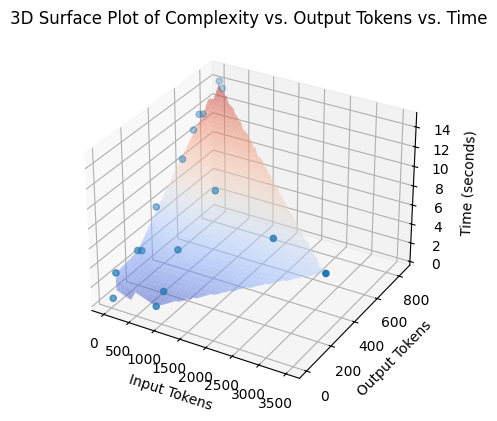

In [65]:
visualize_data_3d_surface(test_results)

In [66]:
test_results

,time,input_tokens,output_tokens,total_tokens,complexity,output
0,3.559001,119,191,310,5,"To calculate the value of John and Jim, you wo..."
1,0.936503,842,22,864,6,B) Employees whose commutes are shortened will...
2,1.843266,850,76,926,6,The passage discusses the inefficiency and cos...
3,6.245045,17,345,362,6,Beans are an incredibly important and nutritio...
4,14.437310,81,829,910,7,Here are a few options you can consider with t...
5,13.620018,114,840,954,9,"The Holocaust, one of the darkest chapters in ..."
6,12.287761,22,688,710,3,The internet has become an indispensable tool ...
7,11.980985,12,722,734,8,The Harry Potter series is a seven-book fantas...
8,11.161739,27,639,666,5,"(Chorus)\n[D] Oh, I'm standing on the [G] edge..."
9,0.611513,29,5,34,6,There are three ducks.


In [67]:
import numpy as np
import statsmodels.api as sm

def create_best_fit_equation(df):
    # Ensure data types are numeric
    df['input_tokens'] = pd.to_numeric(df['input_tokens'], errors='coerce')
    df['output_tokens'] = pd.to_numeric(df['output_tokens'], errors='coerce')
    df['time'] = pd.to_numeric(df['time'], errors='coerce')

    # Drop any rows with NaN values after conversion
    df = df.dropna()

    # Independent variables
    X = df[['input_tokens', 'output_tokens']]
    
    # Adding a constant to the model (for the intercept)
    X = sm.add_constant(X)

    # Dependent variable
    y = df['time']

    # Fit the regression model
    model = sm.OLS(y, X).fit()
    
    # Get the fitted coefficients from the model
    coefficients = model.params

    # Equation of the best fit line
    equation = f"Time = {coefficients['const']} + ({coefficients['input_tokens']} * Input Tokens) + ({coefficients['output_tokens']} * Output Tokens)"

    return equation, model.summary()

In [68]:
equation, summary = create_best_fit_equation(test_results)

/home/adam/.cache/pypoetry/virtualenvs/exploring-llm-inference-time-MslC-3jT-py3.10/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [69]:
equation

'Time = 0.904457029602708 + (9.722066316500595e-05 * Input Tokens) + (0.015757895660444263 * Output Tokens)'

In [70]:
summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   time   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.983
Method:                 Least Squares   F-statistic:                     456.5
Date:                Sat, 02 Dec 2023   Prob (F-statistic):           1.79e-13
Time:                        15:13:42   Log-Likelihood:                -13.677
No. Observations:                  17   AIC:                             33.35
Df Residuals:                      14   BIC:                             35.85
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.9045      0.278      3.249      0.006       0.307       1.501
input_tokens   9.722e-05      0.000      0.611      0.551      -0.000       0.000
output_tokens     0.0158      0.001     29.592      0.000       0.015       0.017
==============================================================================
Omnibus:                       16.466   Durbin-Watson:                   2.428
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               14.874
Skew:                           1.754   Prob(JB):                     0.000589
Kurtosis:                       5.948   Cond. No.                     2.13e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.13e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""